# DCT based Perceptual Hashing

This notebook is also based on [this blog post](http://hackerfactor.com/blog/index.php%3F/archives/432-Looks-Like-It.html) on perceptual hash algorithms. The algorithm in that blog post, in turn, is based on the DCT algorithm from
[pHash](https://www.phash.org/).

## Implementation Exploration

An overview of the algorithm:
1. Resize the source image to 32x32.
2. Convert to Grayscale.
3. Calculate 2d DCT2 of the image.
4. Trim DCT Matrix from 32x32 to only the 8x8 lower frequencies
5. Transform that matrix by comparing each cell to the mean value (excluding the first cell.)
6. Generate the hash by converting the binary matrix to a 64-bit integer.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray
from scipy.fftpack import dct, idct

## Step 0. Import image

In [2]:
rawimg = imread("images/Alyson_Hannigan_200512.jpg")

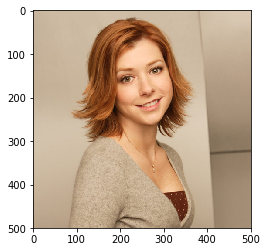

In [3]:
plt.imshow(rawimg)

## Step 1. Resize Image

In [4]:
# scale to 32x32, with anti-aliasing
scaledimg = resize(rawimg, (32, 32), anti_aliasing=True, mode='reflect')

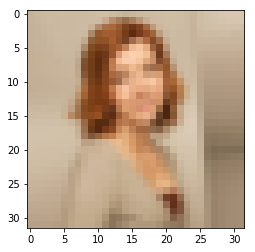

In [5]:
plt.imshow(scaledimg)

## Step 2. Convert to Grayscale

In [6]:
grayimg = rgb2gray(scaledimg)

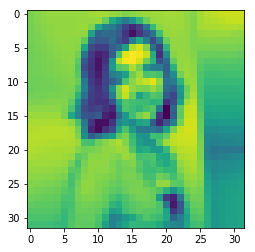

In [7]:
plt.imshow(grayimg)

Note: pyplot adds color to grayscale plots to make the data more visible.

## Step 3. Calculate DCT of image

We will need some help because the library only provides 1d DCT functions.

In [8]:
# 2d DCT
def dct2(block):
    return dct(dct(block.T, norm='ortho').T, norm='ortho')

Now, we generate the 2D-DCT

In [9]:
dimg = dct2(grayimg)
np.shape(dimg)

(32, 32)

### Demonstration of Inverse DCT

Now that we have the DCT of the processed image, here is a demonstration that the DCT includes all the data of the image still, using the Inverse DCT to convert the coefficients back to an image.

In [10]:
# 2d Inverse DCT
def idct2(block):
    return idct(idct(block.T, norm='ortho').T, norm='ortho')

In [11]:
idimg = idct2(dimg)

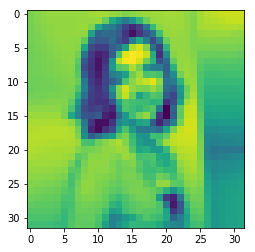

In [12]:
plt.imshow(idimg)

This looks exactly the same, but is it? Well, not *exactly*, there is noise from all the floating point math going on, but it *is* very close.

In [13]:
# test if they are EXACTLY equal
np.array_equiv(np.array(grayimg), np.array(idimg))

False

In [14]:
# test if they are CLOSE to being equal withing a fine
# tolerance (1e-08(absolute) + 1e-05(relative to input))
np.allclose(np.array(grayimg), np.array(idimg))

True

## Step 4. Trim DCT Matrix

Now we have a 32x32 matrix of DCT coeffecients of the processed image. This is great, but that is a lot of data. The higher the frequency of the data, the less important it is (at least, and especially, for our purposes.) Let's trim the matrix down to lower 8x8 coefficients.

In [15]:
trimmed_dimg = dimg[0:8,0:8]
np.shape(trimmed_dimg)

(8, 8)

Let's take another look at the Inverse DCT of this data. Using the 8x8 coeffecient matrix, we will zero-pad it back up to 32x32, and look at the output the Inverse DCT.

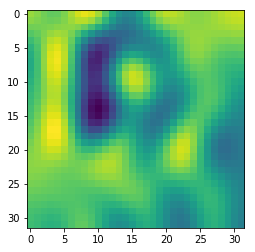

In [16]:
padded_dimg = np.pad(trimmed_dimg, pad_width=((0,24),), mode='constant')
inverse_padded_dct = idct2(padded_dimg)
plt.imshow(inverse_padded_dct)

We can see the output of the inverse of the lower frequency quadrant of the DCT coeffecients still looks *vaguely* like the processed image.

## Step 5. Transform the DCT based on mean value

Now, to further reduce the DCT data, we will calculate the mean value of the trimmed DCT matrix, and generate a binary matrix of bits greater than or less than the mean value.

In [17]:
# find the mean value of the trimmed DCT
davg = np.ravel(trimmed_dimg)[1:].mean()
davg

0.047326735495233876

In [18]:
compbits = (trimmed_dimg > davg)
np.shape(compbits)

(8, 8)

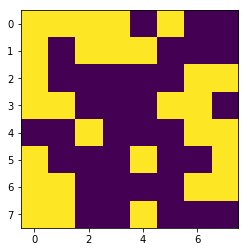

In [19]:
plt.imshow(compbits)

## Step 6. Generate Hash

In [20]:
hashbits = np.ravel(compbits)
np.shape(hashbits)

(64,)

In [21]:
def bool2int(x):
    y = 0
    for i,j in enumerate(x):
        y += j<<i
    return y

In [22]:
hash = bool2int(hashbits)
format(hash, "x")

'13c391c463c11d2f'

## Extra: a 'look at' hash

To take a look at the hash, we will contruct an 8x8 matrix again from the binary hash, normalized from -1 to 1. We will then pad this matrix back up to 32x32 (because that was the context of the original values!) Then we will run another Inverse DCT on this very fuzzy data and see what it looks like.

In [23]:
hashdct = np.pad((compbits * 2 - 1), pad_width=((0,24),), mode='constant')
#hashdct = (compbits * 2  - 1)
np.shape(hashdct)

(32, 32)

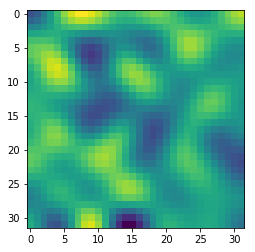

In [24]:
hashim = idct2(hashdct)
plt.imshow(hashim)

# Review

Text(0.5, 1.0, 'Reconstruction from Hash')

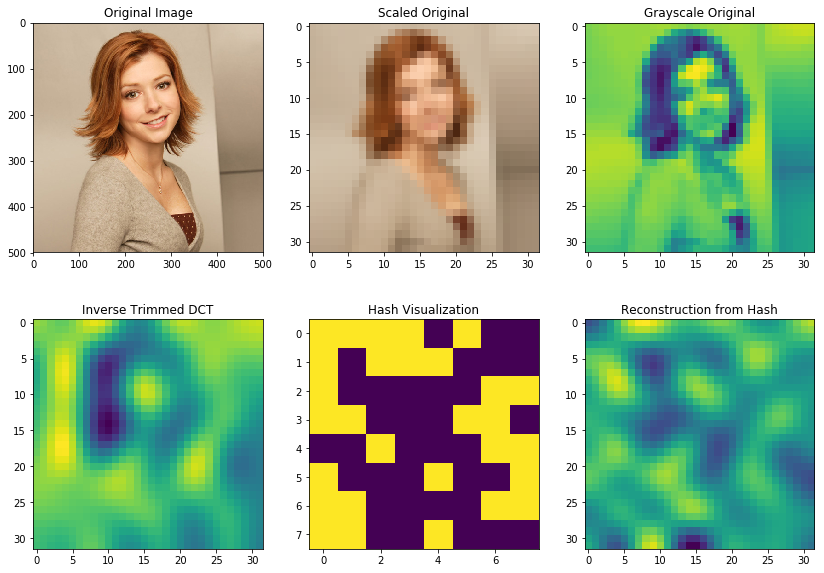

In [25]:
plt.figure(figsize=(14,10))
plt.subplot(2,3,1)
plt.imshow(rawimg)
plt.title('Original Image')
plt.subplot(2,3,2)
plt.imshow(scaledimg)
plt.title('Scaled Original')
plt.subplot(2,3,3)
plt.imshow(grayimg)
plt.title('Grayscale Original')
plt.subplot(2,3,4)
plt.imshow(inverse_padded_dct)
plt.title('Inverse Trimmed DCT')
plt.subplot(2,3,5)
plt.imshow(compbits)
plt.title('Hash Visualization')
plt.subplot(2,3,6)
plt.imshow(hashim)
plt.title('Reconstruction from Hash')

## Implementation

For a slight optimization, we will convert to grayscale before resizing, otherwise this is just all of the above code
together in one function.

In [26]:
def phash(raw):
    img = rgb2gray(raw)
    img = resize(img, (32, 32), anti_aliasing=True, mode='reflect')
    imgdct = dct(dct(img.T, norm='ortho').T, norm='ortho')
    imgdct = imgdct[0:8,0:8]
    avg = np.ravel(imgdct)[1:].mean()
    bits = np.ravel(imgdct > avg)
    y = 0
    for i,j in enumerate(bits):
        y += j<<i
    return y

In [27]:
hash = phash(rawimg)
format(hash,"x")

'13c391c463c11d2f'